In [62]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import logging

logger = logging.getLogger('train')
logger.setLevel(logging.INFO)

In [63]:
import platform

print(platform.platform())

macOS-13.3.1-arm64-arm-64bit


In [64]:
dirpath = "/Users/cristianion/Desktop/satimg_data/NWPU-RESISC45"

In [71]:
labels = [
    'forest',
    'railway_station',
    'tennis_court',
    'basketball_court',
    'river',
    'storage_tank',
    'harbor',
    'terrace',
    'thermal_power_station',
    'golf_course',
    'runway',
    'roundabout',
    'bridge',
    'industrial_area',
    'baseball_diamond',
    'mobile_home_park',
    'overpass',
    'church',
    'chaparral',
    'railway',
    'stadium',
    'medium_residential',
    'sea_ice',
    'intersection',
    'lake',
    'palace',
    'airplane',
    'cloud',
    'sparse_residential',
    'airport',
    'snowberg',
    'parking_lot',
    'commercial_area',
    'rectangular_farmland',
    'island',
    'beach',
    'circular_farmland',
    'dense_residential',
    'ship',
    'mountain',
    'desert',
    'freeway',
    'meadow',
    'wetland',
    'ground_track_field',
]

labels = ['airplane', 'beach']

In [72]:
print(len(labels))

2


In [73]:
filelist = [f"{dirpath}/{f}" for f in os.listdir(dirpath) if f in labels]

In [74]:
result = list(zip(labels, filelist))

In [75]:
df = pd.DataFrame(result, columns=['label', 'dirpath'])

In [76]:
df.head()

,label,dirpath
0,airplane,/Users/cristianion/Desktop/satimg_data/NWPU-RE...
1,beach,/Users/cristianion/Desktop/satimg_data/NWPU-RE...


- acum voi crea lista cu sample-urile de antrenament

In [77]:
data = []
for i, dirpath in enumerate(df["dirpath"]):
    images = os.listdir(dirpath)
    images = [f"{dirpath}/{img}" for img in images]
    rows = [(img, df['label'][i]) for img in images]
    data.extend(rows)

In [78]:
data = pd.DataFrame(data, columns=["imgpath", "label"])

In [79]:
data.head()

,imgpath,label
0,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,airplane
1,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,airplane
2,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,airplane
3,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,airplane
4,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,airplane


In [80]:
data['label'].value_counts()

label
airplane    700
beach       700
Name: count, dtype: int64

- show some examples

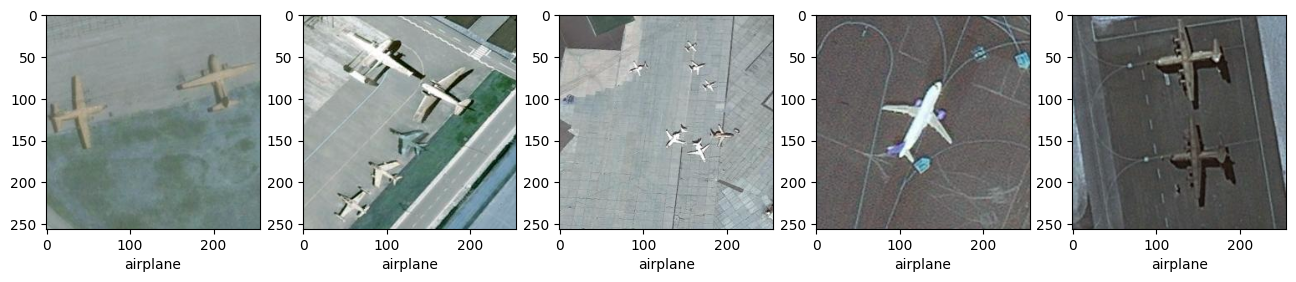

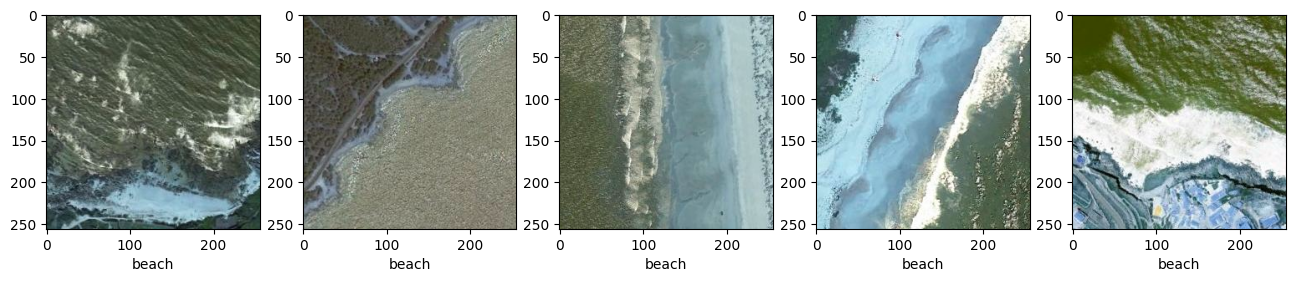

In [81]:
import random
random_labels = random.sample(labels, min(5, len(labels)))
for label in random_labels:
    airplane_dataset = data[data['label'] == label].imgpath
    img_airplane = airplane_dataset.tolist()
    p1 = []
    for img in img_airplane[:5]:
        x = cv2.imread(img)
        p1.append(x)
    
    plt.figure(figsize=(16,10))
    for i in range(1,6):
        plt.subplot(2, 5, i)
        plt.grid(False)
        plt.imshow(p1[i-1])
        plt.xlabel(label)
    plt.show()

Obs:
- Airport and airplane can appear both.
- classification should be separate, we cannot train with airplane 1 and airport 0
- N models can be built, one for each category
- train as categorical model

- save annotations for training

In [82]:
label_index = []
for lab in data.label:
    label_index.append(labels.index(lab))
data['label_index'] = label_index

- add 5-fold for each sample (1,2,3,4,5): 1st 20%, 2nd 20%, etc.

In [83]:
data = data.sample(frac=1).reset_index(drop=True)

In [84]:
folds = []
n = len(data['label_index'])
fold = 0
for i in range(n):
    if ((i / n) * 100) % 20 == 0:
        fold += 1
    folds.append(fold)
data['fold'] = folds


In [85]:
data.sort_values(by=['label_index'], inplace=True)

In [86]:
data.to_csv("dataset_resisc45.csv", index=False)

## Pytorch Libs

In [87]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [88]:
df = pd.read_csv("dataset_resisc45.csv")

In [89]:
folds = sorted(list(df["fold"].unique()))

In [90]:
val_fold=5
df.drop(index=df[df["fold"] == val_fold].index, inplace=True)

In [91]:
df["fold"].value_counts()

fold
1    280
3    280
4    280
2    280
Name: count, dtype: int64

## Train dataset loader

In [92]:
# Dataset loader
import enum

class DatasetTypes(enum.Enum):
    train = "train"
    val = "val"
    test = "test"


class DatasetResisc45(Dataset):
    def __init__(self, dataset_file, dataset_type=None, val_fold=None, transform=None, target_transform=None):
        df = pd.read_csv(dataset_file)
        folds = list(df["fold"].unique())
        if val_fold:
            if val_fold not in folds:
                raise Exception("Fold not found.")
            if dataset_type == DatasetTypes.train:
                df.drop(index=df[df["fold"] == val_fold].index, inplace=True)
            elif dataset_type == DatasetTypes.val:
                df = df[df["fold"] == val_fold]  # keep only the validation fold in dataset
        self.img_labels = df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = cv2.imread(img_path).astype(np.float32) / 255.0
        image = np.moveaxis(image, -1, 0)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [93]:
val_fold = 5

train_set = DatasetResisc45("dataset_resisc45.csv", dataset_type=DatasetTypes.train, val_fold=val_fold)
val_set = DatasetResisc45("dataset_resisc45.csv", dataset_type=DatasetTypes.val, val_fold=val_fold)
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=64, shuffle=True)

In [94]:
def show_sample(dataloader):
    # Display image and label.
    # todo: show images from a batch, with labels underneath
    train_features, train_labels = next(iter(dataloader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(img)
    plt.show()
    print(f"Label: {labels[label]}")

# Classification

- 5-fold cross validation: 20/20/20/20/20
- one-vs-all

### Fully connected model

* 45 categories in softmax
* only fully connected layers

In [95]:
# find CUDA / MPS / CPU device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [96]:
from torch import nn

# Define model architecture
# need to implement dimensions checking!
class LeNet(nn.Module):
    def __init__(self, num_channels):
        super(LeNet, self).__init__()
        
        # 1. initialize first set of CONV => RELU => POOL layers
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=100, kernel_size=(11, 11))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        
        # 2. initialize second set of CONV => RELU => POOL layers
        self.conv2 = nn.Conv2d(in_channels=100, out_channels=300, kernel_size=(5, 5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))

        # 3. initialize second set of CONV => RELU => POOL layers
        self.conv3 = nn.Conv2d(in_channels=300, out_channels=400, kernel_size=(3, 3))
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))

        # 4. initialize second set of CONV => RELU => POOL layers
        self.conv4 = nn.Conv2d(in_channels=400, out_channels=400, kernel_size=(3, 3))
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))

        # 5. initialize second set of CONV => RELU => POOL layers
        self.conv5 = nn.Conv2d(in_channels=400, out_channels=200, kernel_size=(3, 3))
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        
        self.flatten = nn.Flatten()
        
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=3200, out_features=512)
        self.relu6 = nn.ReLU()
        
        # initialize our softmax classifier
        self.fc2 = nn.Linear(in_features=512, out_features=len(labels))
        # self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        # pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)
        # output = self.logSoftmax(x)
        # return the output predictions
        return x

In [97]:
# create model
def create_model():
    print(f"device: {device}")
    model = LeNet(3).to(device) # create model on device
    print(str(model))
    return model

In [98]:
model = create_model()

device: mps
LeNet(
  (conv1): Conv2d(3, 100, kernel_size=(11, 11), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 300, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(300, 400, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(400, 400, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(400, 200, kernel_size=(3, 3), stride=(1, 1))
  (relu5): ReLU()
  (maxpool5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3200, o

## Random initialisation validation

In [99]:
X = torch.rand(5, 3, 256, 256, device=device)
print(f"Feature batch shape: {X.size()}")
logits = model(X)
print(logits)
pred_probab = nn.Softmax(dim=1)(logits)
print(pred_probab)
y_pred = pred_probab.argmax(1)
y_pred = [labels[ind] for ind in y_pred]
print(f"Predicted class: {y_pred}")

Feature batch shape: torch.Size([5, 3, 256, 256])
tensor([[0.0150, 0.0213],
        [0.0148, 0.0212],
        [0.0149, 0.0212],
        [0.0150, 0.0212],
        [0.0148, 0.0212]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4984, 0.5016],
        [0.4984, 0.5016],
        [0.4984, 0.5016],
        [0.4984, 0.5016],
        [0.4984, 0.5016]], device='mps:0', grad_fn=<SoftmaxBackward0>)
Predicted class: ['beach', 'beach', 'beach', 'beach', 'beach']


In [100]:
X, Y = next(iter(train_dataloader))
X, Y = X.to(device), Y.to(device)
print(f"Feature batch shape: {X.size()}")
print(f"Labels batch shape: {Y.size()}")
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(y_pred)
y_pred = [labels[ind] for ind in y_pred]
print(f"Predicted class: {y_pred}")

Feature batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: torch.Size([64])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='mps:0')
Predicted class: ['beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach']


In [101]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(dataloader, model):
    print("Started train.")
    size = len(dataloader.dataset)
    
    model.train()  # set model to train mode

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def val(dataloader, model):
    print("Started validation.")
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval() # set model to evaluation mode

    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (nn.Softmax(dim=1)(pred).argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## 5 Fold train validation

In [102]:
for val_fold in folds:
    print(f"Fold: {val_fold}\n------------------------------")
    model = create_model()
    train_set = DatasetResisc45("dataset_resisc45.csv", dataset_type=DatasetTypes.train, val_fold=val_fold)
    val_set = DatasetResisc45("dataset_resisc45.csv", dataset_type=DatasetTypes.val, val_fold=val_fold)
    train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(val_set, batch_size=64, shuffle=False)

    epochs = 5
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model)
        val(val_dataloader, model)
    

Fold: 1
------------------------------
device: mps
LeNet(
  (conv1): Conv2d(3, 100, kernel_size=(11, 11), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 300, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(300, 400, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(400, 400, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(400, 200, kernel_size=(3, 3), stride=(1, 1))
  (relu5): ReLU()
  (maxpool5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=

KeyboardInterrupt: 